In [588]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [589]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

# Feature 설명

index   
gender: 성별   (o)
car: 차량 소유 여부   (o)
reality: 부동산 소유 여부   (o)
child_num: 자녀 수   
income_total: 연간 소득  (o)
income_type: 소득 분류   
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   
edu_type: 교육 수준   
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   
family_type: 결혼 여부   
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   
house_type: 생활 방식   
['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   
DAYS_BIRTH: 출생일   (o)
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
DAYS_EMPLOYED: 업무 시작일   (o)   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
FLAG_MOBIL: 핸드폰 소유 여부  (o) 
work_phone: 업무용 전화 소유 여부   (o)
phone: 전화 소유 여부  (o) 
email: 이메일 소유 여부   (o)
occyp_type: 직업 유형	   												
family_size: 가족 규모  (o) 
begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미 (o)     

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   



# DEF 모음

In [590]:
def box_value(col):
    Q1 = abs(train[train[col] > 0][col].quantile(0.25))
    Q2 = abs(train[train[col] > 0][col].quantile(0.50))
    Q3 = abs(train[train[col] > 0][col].quantile(0.75))
    IQR = Q3 - Q1

    return Q1, Q2, Q3, IQR

# Preprocessing

## 1. DAYS_EMPLOYED

In [591]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()


365243    4438
Name: DAYS_EMPLOYED, dtype: int64

In [592]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

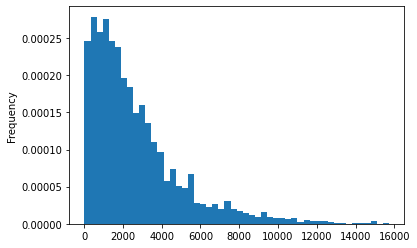

In [593]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [594]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int64

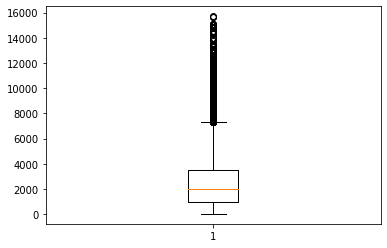

In [595]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [596]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.5 Q3 : 3506.0 IQR : 2536.5


In [597]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

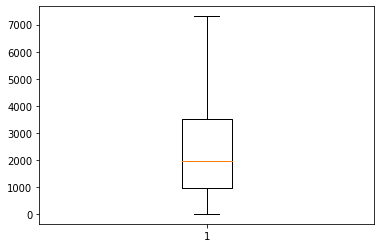

In [598]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [599]:
def dayEMP_category(day_ep):
    ep = ''
    if day_ep == 0: ep = 0
    elif day_ep <= Q1: ep = 1
    elif day_ep <= Q2: ep = 2
    elif day_ep <= Q3: ep = 3
    elif day_ep > Q3: ep = 4
       
    return ep


In [600]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))

In [601]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})

In [602]:
train['DAYS_EMPLOYED'].value_counts()

D    6763
C    5506
B    5505
A    4438
E    4245
Name: DAYS_EMPLOYED, dtype: int64

## Begin_month

<AxesSubplot:ylabel='Frequency'>

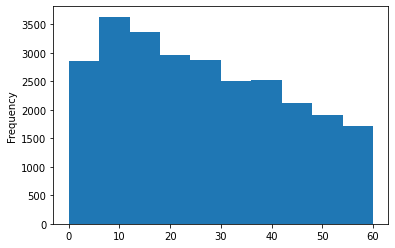

In [603]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [604]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [605]:
begin_catagory = [0,1,1,2,2,3,3,4,4,4]
train['begin_month'] = pd.cut(train['begin_month'], bins = 10, labels= begin_catagory, ordered= False)
test['begin_month'] = pd.cut(test['begin_month'], bins = 10, labels= begin_catagory, ordered= False)

In [606]:
train['begin_month'] = train['begin_month'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})
test['begin_month'] = test['begin_month'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})

In [607]:
train['begin_month'].value_counts()

B    6911
C    5773
E    5362
D    4965
A    3446
Name: begin_month, dtype: int64

## income_total

<AxesSubplot:ylabel='Frequency'>

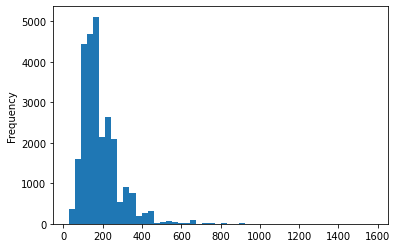

In [608]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

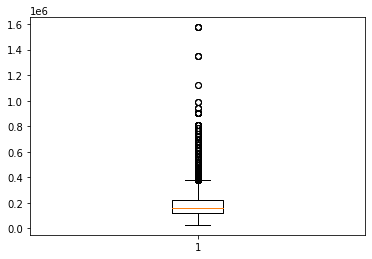

In [609]:
plt.boxplot(train['income_total'])
plt.show()

In [610]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [611]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

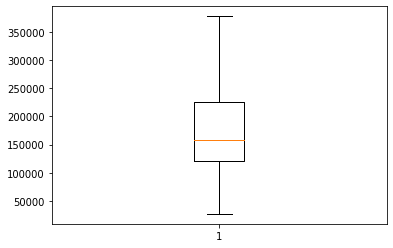

In [612]:
plt.boxplot(train['income_total'])
plt.show()

In [613]:
def box_category(value):
    ep = ''
    if value <= Q1: ep = 0
    elif value <= Q2: ep = 1
    elif value <= Q3: ep = 2
    elif value > Q3: ep = 3
       
    return ep

In [614]:
train['income_total'] = train['income_total'].apply(lambda x : box_category(x))
test['income_total'] = test['income_total'].apply(lambda x : box_category(x))

In [615]:
train['income_total'] = train['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'})
test['income_total'] = test['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'})

In [616]:
train['income_total'].value_counts()

C    7334
A    6751
B    6685
D    5687
Name: income_total, dtype: int64

## Gender, Car, Reality

In [617]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## DAYS_BIRTH

In [618]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

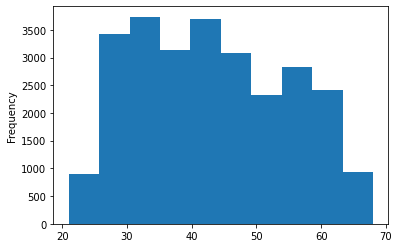

In [619]:
train['DAYS_BIRTH'].plot(kind='hist')

In [620]:
def birth_catagory(value):
    ep = ''
    if value <= 30: ep = 'A'
    elif value <= 40: ep = 'B'
    elif value <= 50: ep = 'C'
    elif value <= 60: ep = 'D'
    elif value < 70: ep = 'E'
       
    return ep

In [621]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))

In [622]:
train['DAYS_BIRTH'].value_counts()

B    7689
C    6542
D    5730
A    4324
E    2172
Name: DAYS_BIRTH, dtype: int64

## family_size

In [623]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [624]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [625]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [626]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [627]:
train['family_size'].value_counts()

B    14106
A     5109
C     4632
D     2610
Name: family_size, dtype: int64

## work_phone, phone, email, FLAG_MOBIL

In [629]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])
print('work_phone :')
print(train['work_phone'].value_counts())
print('--------------')

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])
print(train['phone'].value_counts())
print('--------------')


train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])
print(train['email'].value_counts())
print('--------------')

train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([0,1], ['N','Y'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([0,1], ['N','Y'])
print(train['FLAG_MOBIL'].value_counts())
print('--------------')

work_phone :
N    20511
Y     5946
Name: work_phone, dtype: int64
--------------
N    18672
Y     7785
Name: phone, dtype: int64
--------------
N    24042
Y     2415
Name: email, dtype: int64
--------------
Y    26457
Name: FLAG_MOBIL, dtype: int64
--------------


In [630]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  object 
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  object 
 11  DAYS_EMPLOYED  26457 non-null  object 
 12  FLAG_MOBIL     26457 non-null  object 
 13  work_phone     26457 non-null  object 
 14  phone          26457 non-null  object 
 15  email          26457 non-null  object 
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  object 
 18  begin_

## occyp_type

In [631]:
train = train.drop('occyp_type', axis=1)
test = test.drop('occyp_type', axis=1)

## 원핫인코딩

In [632]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

In [633]:
train_x = pd.get_dummies(train_x, drop_first= True)
test_x = pd.get_dummies(test_x, drop_first= True)

In [634]:
print(train_x.shape, test_x.shape, train_y.shape)

(26457, 42) (10000, 42) (26457, 1)


## 모델링

In [635]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


ada_pred=AdaBoostClassifier()
ada_pred.fit(X_train, y_train)
y_pred=ada_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 42)
(19842, 1)
Validation set: 
(6615, 42)
(6615, 1)
log_loss: 1.0879560927339156


In [637]:
rf_pred=RandomForestClassifier(random_state=2021)
rf_pred.fit(X_train, y_train)
y_pred=rf_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 1.4709883334359288


In [638]:
gb_pred=GradientBoostingClassifier(random_state=2021)
gb_pred.fit(X_train, y_train)
y_pred=gb_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.8419826704439529


In [641]:
k = 0.03
learn_list = []
loss_list = []
for i in range(10):
    cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.07)
    cat_pred.fit(X_train, y_train)
    y_pred=cat_pred.predict_proba(X_val)
    learn_list.append(k)
    learn_list.append(log_loss(to_categorical(y_val['credit']), y_pred))
    k += 0.01
loss_list

0:	learn: 1.0853386	total: 9.53ms	remaining: 9.52s
1:	learn: 1.0730386	total: 18.1ms	remaining: 9.05s
2:	learn: 1.0615495	total: 25.9ms	remaining: 8.62s
3:	learn: 1.0508448	total: 29.6ms	remaining: 7.37s
4:	learn: 1.0407994	total: 37.3ms	remaining: 7.43s
5:	learn: 1.0314173	total: 42.2ms	remaining: 7s
6:	learn: 1.0225381	total: 48.9ms	remaining: 6.94s
7:	learn: 1.0140526	total: 53.4ms	remaining: 6.62s
8:	learn: 1.0036914	total: 60.1ms	remaining: 6.61s
9:	learn: 0.9961469	total: 66.6ms	remaining: 6.59s
10:	learn: 0.9893375	total: 73ms	remaining: 6.57s
11:	learn: 0.9828425	total: 79.8ms	remaining: 6.57s
12:	learn: 0.9765019	total: 86.1ms	remaining: 6.54s
13:	learn: 0.9706299	total: 95.1ms	remaining: 6.7s
14:	learn: 0.9645341	total: 102ms	remaining: 6.67s
15:	learn: 0.9592639	total: 110ms	remaining: 6.79s
16:	learn: 0.9545390	total: 114ms	remaining: 6.57s
17:	learn: 0.9500199	total: 120ms	remaining: 6.56s
18:	learn: 0.9451273	total: 127ms	remaining: 6.54s
19:	learn: 0.9389493	total: 140ms

[]

In [644]:
cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.07)
cat_pred.fit(X_train, y_train)
y_pred=cat_pred.predict_proba(X_val)

0:	learn: 1.0682652	total: 8.37ms	remaining: 8.36s
1:	learn: 1.0427256	total: 16.8ms	remaining: 8.36s
2:	learn: 1.0209117	total: 24.7ms	remaining: 8.19s
3:	learn: 1.0023384	total: 28.1ms	remaining: 7s
4:	learn: 0.9861848	total: 35.8ms	remaining: 7.13s
5:	learn: 0.9723483	total: 41.4ms	remaining: 6.85s
6:	learn: 0.9600600	total: 54ms	remaining: 7.66s
7:	learn: 0.9438688	total: 61.2ms	remaining: 7.59s
8:	learn: 0.9299005	total: 68.9ms	remaining: 7.59s
9:	learn: 0.9220237	total: 84.7ms	remaining: 8.38s
10:	learn: 0.9149249	total: 100ms	remaining: 9.01s
11:	learn: 0.9083811	total: 116ms	remaining: 9.55s
12:	learn: 0.8989896	total: 152ms	remaining: 11.5s
13:	learn: 0.8940368	total: 168ms	remaining: 11.8s
14:	learn: 0.8897507	total: 182ms	remaining: 12s
15:	learn: 0.8827824	total: 213ms	remaining: 13.1s
16:	learn: 0.8796722	total: 220ms	remaining: 12.7s
17:	learn: 0.8738663	total: 235ms	remaining: 12.8s
18:	learn: 0.8712589	total: 258ms	remaining: 13.3s
19:	learn: 0.8686830	total: 271ms	rema

In [645]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_pred)

0:	learn: 1.0682585	total: 15.9ms	remaining: 15.8s
1:	learn: 1.0427123	total: 28.3ms	remaining: 14.1s
2:	learn: 1.0208009	total: 38.4ms	remaining: 12.8s
3:	learn: 1.0022367	total: 43.4ms	remaining: 10.8s
4:	learn: 0.9861376	total: 54.2ms	remaining: 10.8s
5:	learn: 0.9723431	total: 62.2ms	remaining: 10.3s
6:	learn: 0.9593781	total: 70.2ms	remaining: 9.96s
7:	learn: 0.9434997	total: 78.7ms	remaining: 9.76s
8:	learn: 0.9297695	total: 86.3ms	remaining: 9.5s
9:	learn: 0.9216245	total: 94.8ms	remaining: 9.38s
10:	learn: 0.9145940	total: 113ms	remaining: 10.2s
11:	learn: 0.9085038	total: 125ms	remaining: 10.3s
12:	learn: 0.8993497	total: 137ms	remaining: 10.4s
13:	learn: 0.8944201	total: 148ms	remaining: 10.4s
14:	learn: 0.8901523	total: 174ms	remaining: 11.4s
15:	learn: 0.8833675	total: 189ms	remaining: 11.6s
16:	learn: 0.8802880	total: 200ms	remaining: 11.6s
17:	learn: 0.8747012	total: 215ms	remaining: 11.7s
18:	learn: 0.8720815	total: 229ms	remaining: 11.8s
19:	learn: 0.8695764	total: 252m

In [646]:
submission.loc[:,1:]=my_submission

In [647]:
submission

,index,0,1,2
0,26457,0.071829,0.117037,0.811134
1,26458,0.181041,0.215497,0.603462
2,26459,0.117301,0.142191,0.740507
3,26460,0.117893,0.170858,0.711248
4,26461,0.039871,0.137286,0.822843
...,...,...,...,...
9995,36452,0.130982,0.197396,0.671622
9996,36453,0.090675,0.231224,0.678100
9997,36454,0.098250,0.118306,0.783444
9998,36455,0.087850,0.320579,0.591571


In [648]:
submission.to_csv('../Data/Catboost_1.csv', index=False)